In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import re

In [2]:
abspath = r'C:\Users\Andy\PycharmProjects\finrlpaper2\MT-DRL-Pytorch'
os.chdir(abspath)
cwd_ = os.getcwd() # get current working directory
cwd_

'C:\\Users\\Andy\\PycharmProjects\\finrlpaper2\\MT-DRL-Pytorch'

In [3]:
results_path = "results"

runfolder = "07-20-2021_14-26-34_ppoCustomBase_logU_mlp_shared_newNoShort_fm3_st_detTrue_entropy0.005"

In [4]:
# results "07-18-2021_02-09-48_ppoCustomBase_logU_mlp_shared_paper_fm3_st_detFalse"
results_folder_path =  os.path.join(abspath, 
                                    results_path, 
                                    runfolder)

seed1 = "randomSeed0"
seed2 = "randomSeed5"
seed3 = "randomSeed23"
seed4 = "randomSeed7774"
seed5 = "randomSeed11112"
seedlist = [seed1, seed2, seed3, seed4, seed5]

#### get data

In [5]:
fulldf = pd.read_csv(os.path.join(abspath, "data", "preprocessed", "US_stocks_Wharton_full_DJIA.csv"), index_col=0)
fulldf = fulldf[(fulldf.index >=20151001) & (fulldf.index <=20210406)]
fulldf

tic    adjcp      high       low      volume      macd     rsi_21  \
datadate                                                                       
20151001  AAPL   27.395   27.4050   26.8275  63849470.0 -0.213248  43.213665   
20151001  AMGN  140.230  140.6400  136.6000   4669185.0 -5.284907  40.669088   
20151001   AXP   73.890   74.6000   73.2100   4736708.0 -0.765425  43.103747   
20151001    BA  130.610  131.7890  128.9801   2850888.0 -1.665138  43.430153   
20151001   CAT   64.390   66.1000   63.6100   7932525.0 -3.038283  31.633191   
...        ...      ...       ...       ...         ...       ...        ...   
20210406   UNH  364.370  369.7900  362.7200   2697863.0  7.370597  57.055247   
20210406    VZ   59.110   59.1100   58.6800  12187890.0  0.736307  62.000371   
20210406   WBA   55.700   57.0500   55.5250   4663166.0  1.492350  64.547485   
20210406   WMT  140.100  140.9482  138.5200  10328330.0  0.706261  57.499379   
20210406   XOM   56.340   57.5399   56.2600  18902130.0  0.346850  52.987405   

              cci_21      dx_21  ret_vola_7d  return_daily  log_return_daily  \
datadate                                                                       
20151001 -142.482641  46.629579     0.015355     -0.006528         -0.006549   
20151001  -97.725969  45.474166     0.028175      0.013809          0.013714   
20151001 -104.996290  12.020032     0.012065     -0.003238         -0.003243   
20151001  -62.100748  21.575320     0.014855     -0.002596         -0.002600   
20151001 -117.979620  52.201438     0.025298     -0.014841         -0.014952   
...              ...        ...          ...           ...               ...   
20210406   19.275651   7.728576     0.012503     -0.015695         -0.015820   
20210406  132.417609  41.850301     0.007988      0.004077          0.004068   
20210406  139.529297  45.141083     0.020678     -0.019366         -0.019556   
20210406  197.681762  46.171494     0.011346      0.004805          0.004794   
20210406  -49.880508   5.182935     0.019065     -0.002832         -0.002836   

          ret_vola_21d  ret_vola_63d  dow30Close  
datadate                                          
20151001      0.018394      0.021585    16272.01  
20151001      0.024069      0.022874    16272.01  
20151001      0.011729      0.015080    16272.01  
20151001      0.013862      0.015428    16272.01  
20151001      0.020367      0.017881    16272.01  
...                ...           ...         ...  
20210406      0.010532      0.013329    33430.24  
20210406      0.009753      0.012216    33430.24  
20210406      0.020748      0.020207    33430.24  
20210406      0.011360      0.013792    33430.24  
20210406      0.018651      0.023227    33430.24  

[37449 rows x 15 columns]

In [6]:
us_df = pd.read_csv(os.path.join(abspath, "data", "preprocessed", "US_stocks_WDB_full.csv"), index_col=0)
us_df = us_df[(us_df.datadate >=20151001) & (us_df.datadate <=20210406)]
us_df.datadate = pd.to_datetime(us_df.datadate, format='%Y%m%d')

### Benchmark 1: dow30 index

In [7]:
dow30 = pd.DataFrame(fulldf["dow30Close"])
dow30.index = pd.to_datetime(dow30.index, format='%Y%m%d')

###  Benchmark 2: equal weighted portfolio

In [8]:
# make equal weights PF
equal_weights = [1/len(fulldf.tic.unique())]*len(fulldf.tic.unique())

In [9]:
full_df_fact = fulldf.reset_index()[["datadate", "tic", "return_daily"]]
full_df_fact.index = full_df_fact.reset_index()["datadate"].factorize()[0]
full_df_fact["equal_weight"] = 1/len(fulldf.tic.unique())
full_df_fact["equal_weighted_return_daily"] = full_df_fact["return_daily"] * full_df_fact["equal_weight"]
full_df_fact["ew_pfret"] = np.NaN

for day in full_df_fact.index.unique():
    pfret = full_df_fact[full_df_fact.index == day]["equal_weighted_return_daily"].sum()
    full_df_fact.loc[full_df_fact.index == day, "ew_pfret"] = pfret
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
eq_pf = full_df_fact[["datadate", "ew_pfret"]]
eq_pf.drop_duplicates(keep="last", inplace=True)
eq_pf.set_index("datadate", inplace=True)
#eq_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [10]:
# create price:
eq_pf["cumret"] = (eq_pf["ew_pfret"]+1).cumprod()
#eq_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#total return by hand:
eq_pf["cumret"][-1] / eq_pf["cumret"][0]-1

1.06920518613099

In [12]:
# get ew portfolio metrics
import ffn
perf = eq_pf["cumret"].calc_stats()

# now we can access the statistics like this, for example: (ann = annualized)
sharpe_ratio_daily_ann = perf.daily_sharpe
total_return = perf.total_return
#avg_daily_return_ann = perf.daily_mean
std_daily_return_ann = perf.daily_vol
maxdd = perf.max_drawdown
#avg_dd = perf.avg_drawdown
avg_dd_days = perf.avg_drawdown_days

print(sharpe_ratio_daily_ann)
print(total_return)
print(std_daily_return_ann)
print(maxdd)

0.7826733132771603
1.06920518613099
0.19276860968003934
-0.34394496920914


In [13]:
# create mean variance portfolio as benchmark
#import pypfopt
#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
#from pypfopt.cla import CLA
#from pypfopt.plotting import Plotting
#from matplotlib.ticker import FuncFormatter
# do in colab if time

full_df_fact = fulldf.reset_index()[["datadate", "tic", "return_daily", "volume"]]
full_df_fact

datadate   tic  return_daily      volume
0      20151001  AAPL     -0.006528  63849470.0
1      20151001  AMGN      0.013809   4669185.0
2      20151001   AXP     -0.003238   4736708.0
3      20151001    BA     -0.002596   2850888.0
4      20151001   CAT     -0.014841   7932525.0
...         ...   ...           ...         ...
37444  20210406   UNH     -0.015695   2697863.0
37445  20210406    VZ      0.004077  12187890.0
37446  20210406   WBA     -0.019366   4663166.0
37447  20210406   WMT      0.004805  10328330.0
37448  20210406   XOM     -0.002832  18902130.0

[37449 rows x 4 columns]

### Benchmark 3: Volume weighted portfolio

In [14]:
# calculate weekly volume
full_df_fact.index = full_df_fact.reset_index()["datadate"].factorize()[0]

for tic in full_df_fact.tic.unique():
    full_df_fact.loc[full_df_fact.tic == tic, "weekly_volume"] =\
                full_df_fact.loc[full_df_fact.tic == tic, "volume"].rolling(7, min_periods=0).mean()
    

In [15]:
#pd.set_option('display.max_rows', 500)
#full_df_fact[full_df_fact.tic == "AAPL"][0:100]

In [16]:
#full_df_fact

In [17]:
# calculate weekly portfolio volume each day
# create volume weighted pf
# calculate weekly volume for portfolio
for day in full_df_fact.index.unique():
    pfvolweekly = full_df_fact[full_df_fact.index == day]["weekly_volume"].sum()
    full_df_fact.loc[full_df_fact.index == day, "pf_vol_weekly"] = pfvolweekly
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
#full_df_fact

In [18]:
# calculate volume weights
full_df_fact["volweight"] = full_df_fact["weekly_volume"] / full_df_fact["pf_vol_weekly"]
# calculate volume-weighted return of each stock
full_df_fact["vw_ret"] = full_df_fact["volweight"] * full_df_fact["return_daily"]
# calculate volume-weighted portfolio return
for day in full_df_fact.index.unique():
    pfret = full_df_fact[full_df_fact.index == day]["vw_ret"].sum()
    full_df_fact.loc[full_df_fact.index == day, "vw_pfret"] = pfret
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
vw_pf = full_df_fact[["datadate", "vw_pfret"]]
vw_pf.drop_duplicates(keep="last", inplace=True)
vw_pf.set_index("datadate", inplace=True)
vw_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


vw_pfret
datadate            
2015-10-01 -0.002102
2015-10-02  0.013902
2015-10-05  0.019334
2015-10-06  0.001580
2015-10-07  0.007939
...              ...
2021-03-30 -0.008448
2021-03-31  0.004298
2021-04-01  0.007719
2021-04-05  0.014228
2021-04-06 -0.004025

[1387 rows x 1 columns]

In [20]:
# create price:
vw_pf["cumret"] = (vw_pf["vw_pfret"]+1).cumprod()
vw_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


vw_pfret    cumret
datadate                      
2015-10-01 -0.002102  0.997898
2015-10-02  0.013902  1.011770
2015-10-05  0.019334  1.031332
2015-10-06  0.001580  1.032962
2015-10-07  0.007939  1.041163
...              ...       ...
2021-03-30 -0.008448  2.164513
2021-03-31  0.004298  2.173817
2021-04-01  0.007719  2.190596
2021-04-05  0.014228  2.221764
2021-04-06 -0.004025  2.212822

[1387 rows x 2 columns]

In [21]:
# get ew portfolio metrics
import ffn
perf = vw_pf["cumret"].calc_stats()

# now we can access the statistics like this, for example: (ann = annualized)
sharpe_ratio_daily_ann = perf.daily_sharpe
total_return = perf.total_return
#avg_daily_return_ann = perf.daily_mean
std_daily_return_ann = perf.daily_vol
maxdd = perf.max_drawdown
#avg_dd = perf.avg_drawdown
avg_dd_days = perf.avg_drawdown_days

print(sharpe_ratio_daily_ann)
print(total_return)
print(std_daily_return_ann)
print(maxdd)

0.8007137906404647
1.2174841356951083
0.2079739631274576
-0.32966745664303976


c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


## GET PERFORMANCE RESULTS ON TEST SET - MAIN PERFORMANCE

### Get policy actions

In [22]:
policy_actions = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "policy_actions", 
                                f"policy_actions_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    policy_actions.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Andy\\PycharmProjects\\finrlpaper2\\MT-DRL-Pytorch\\results\\07-20-2021_14-26-34_ppoCustomBase_logU_mlp_shared_newNoShort_fm3_st_detTrue_entropy0.005\\randomSeed0\\policy_actions\\policy_actions_test_ppoCustomBase_ep1_totalSteps_63_finalStateCounter_1.csv'

### Get transformed policy actions for benchmarking

In [105]:
policy_actions_trans = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "policy_actions_trans", 
                                f"policy_actions_trans_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    policy_actions_trans.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


#### IF ITS WEIGHTS:

In [202]:
seed = 1
for df in policy_actions_trans:
    # change weide format to long
    df_ = pd.melt(df.reset_index(), id_vars=['datadate'], var_name='tic', value_name=f'policy_weight_seed{seed}')
    df_.sort_values(by=["datadate", "tic"], inplace=True)
    df_.reset_index(inplace=True)
    df_ = df_[["datadate", "tic", f'policy_weight_seed{seed}']]
    # merge with full dataframe
    full_df_fact = full_df_fact.merge(df_)
    # for each tick; calculate policy-weight weighted returns with shift funtction (since we get return of tommorow with today's weights)
    for tic in full_df_fact.tic.unique():
        full_df_fact.loc[full_df_fact.tic==tic, f"polw_ret_seed{seed}"] = \
                        full_df_fact.loc[full_df_fact.tic==tic, f'policy_weight_seed{seed}'].shift(1)* \
                                    full_df_fact.loc[full_df_fact.tic==tic, "return_daily"]
    seed +=1

In [208]:
#full_df_fact.iloc[0:100] # its correct
full_df_fact

datadate   tic  return_daily  vw_pfret  polw_pfret_allseeds  \
0      2015-10-01  AAPL     -0.006528 -0.002102            -0.000309   
1      2015-10-01  AMGN      0.013809 -0.002102            -0.000309   
2      2015-10-01   AXP     -0.003238 -0.002102            -0.000309   
3      2015-10-01    BA     -0.002596 -0.002102            -0.000309   
4      2015-10-01   CAT     -0.014841 -0.002102            -0.000309   
...           ...   ...           ...       ...                  ...   
617485 2021-04-06   UNH     -0.015695 -0.004025            -0.004538   
617486 2021-04-06    VZ      0.004077 -0.004025            -0.004538   
617487 2021-04-06   WBA     -0.019366 -0.004025            -0.004538   
617488 2021-04-06   WMT      0.004805 -0.004025            -0.004538   
617489 2021-04-06   XOM     -0.002832 -0.004025            -0.004538   

          cumret  policy_weight_seed1  polw_ret_seed1  policy_weight_seed2  \
0       0.999691             0.028766             NaN             0.058465   
1       0.999382             0.059574             NaN             0.027082   
2       0.999074             0.044497             NaN             0.054842   
3       0.998765             0.040078             NaN             0.035210   
4       0.998457             0.045083             NaN             0.038666   
...          ...                  ...             ...                  ...   
617485  0.000000             0.040318       -0.000762             0.015117   
617486  0.000000             0.029858        0.000049             0.041985   
617487  0.000000             0.017470       -0.000449             0.035727   
617488  0.000000             0.079487        0.000232             0.046928   
617489  0.000000             0.021232       -0.000085             0.020814   

        polw_ret_seed2  policy_weight_seed3  polw_ret_seed3  \
0                  NaN             0.051871             NaN   
1                  NaN             0.063425             NaN   
2                  NaN             0.031123             NaN   
3                  NaN             0.027536             NaN   
4                  NaN             0.029551             NaN   
...                ...                  ...             ...   
617485       -0.000520             0.028709       -0.000570   
617486        0.000224             0.049609        0.000151   
617487       -0.000799             0.043007       -0.000756   
617488        0.000276             0.038728        0.000156   
617489       -0.000097             0.035810       -0.000070   

        policy_weight_seed4  polw_ret_seed4  policy_weight_seed5  \
0                  0.048677             NaN             0.054920   
1                  0.042166             NaN             0.063806   
2                  0.045258             NaN             0.024129   
3                  0.033756             NaN             0.050310   
4                  0.030458             NaN             0.029798   
...                     ...             ...                  ...   
617485             0.039237       -0.000454             0.050023   
617486             0.019497        0.000064             0.028885   
617487             0.016201       -0.000264             0.024801   
617488             0.014782        0.000071             0.061773   
617489             0.021923       -0.000060             0.046486   

        polw_ret_seed5  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
617485       -0.000756  
617486        0.000109  
617487       -0.000462  
617488        0.000254  
617489       -0.000108  

[617490 rows x 16 columns]

In [205]:
#full_df_fact.index = full_df_fact.reset_index()["datadate"].factorize()[0]
full_df_fact

datadate   tic  return_daily  vw_pfret  polw_pfret_allseeds  \
0      2015-10-01  AAPL     -0.006528 -0.002102            -0.000309   
1      2015-10-01  AMGN      0.013809 -0.002102            -0.000309   
2      2015-10-01   AXP     -0.003238 -0.002102            -0.000309   
3      2015-10-01    BA     -0.002596 -0.002102            -0.000309   
4      2015-10-01   CAT     -0.014841 -0.002102            -0.000309   
...           ...   ...           ...       ...                  ...   
617485 2021-04-06   UNH     -0.015695 -0.004025            -0.004538   
617486 2021-04-06    VZ      0.004077 -0.004025            -0.004538   
617487 2021-04-06   WBA     -0.019366 -0.004025            -0.004538   
617488 2021-04-06   WMT      0.004805 -0.004025            -0.004538   
617489 2021-04-06   XOM     -0.002832 -0.004025            -0.004538   

          cumret  policy_weight_seed1  polw_ret_seed1  policy_weight_seed2  \
0       0.999691             0.028766             NaN             0.058465   
1       0.999382             0.059574             NaN             0.027082   
2       0.999074             0.044497             NaN             0.054842   
3       0.998765             0.040078             NaN             0.035210   
4       0.998457             0.045083             NaN             0.038666   
...          ...                  ...             ...                  ...   
617485  0.000000             0.040318       -0.000762             0.015117   
617486  0.000000             0.029858        0.000049             0.041985   
617487  0.000000             0.017470       -0.000449             0.035727   
617488  0.000000             0.079487        0.000232             0.046928   
617489  0.000000             0.021232       -0.000085             0.020814   

        polw_ret_seed2  policy_weight_seed3  polw_ret_seed3  \
0                  NaN             0.051871             NaN   
1                  NaN             0.063425             NaN   
2                  NaN             0.031123             NaN   
3                  NaN             0.027536             NaN   
4                  NaN             0.029551             NaN   
...                ...                  ...             ...   
617485       -0.000520             0.028709       -0.000570   
617486        0.000224             0.049609        0.000151   
617487       -0.000799             0.043007       -0.000756   
617488        0.000276             0.038728        0.000156   
617489       -0.000097             0.035810       -0.000070   

        policy_weight_seed4  polw_ret_seed4  policy_weight_seed5  \
0                  0.048677             NaN             0.054920   
1                  0.042166             NaN             0.063806   
2                  0.045258             NaN             0.024129   
3                  0.033756             NaN             0.050310   
4                  0.030458             NaN             0.029798   
...                     ...             ...                  ...   
617485             0.039237       -0.000454             0.050023   
617486             0.019497        0.000064             0.028885   
617487             0.016201       -0.000264             0.024801   
617488             0.014782        0.000071             0.061773   
617489             0.021923       -0.000060             0.046486   

        polw_ret_seed5  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
617485       -0.000756  
617486        0.000109  
617487       -0.000462  
617488        0.000254  
617489       -0.000108  

[617490 rows x 16 columns]

In [206]:
full_df_fact.sort_values(by=["datadate"])

datadate   tic  return_daily  vw_pfret  polw_pfret_allseeds  \
0      2015-10-01  AAPL     -0.006528 -0.002102            -0.000309   
26     2015-10-01   XOM     -0.003900 -0.002102            -0.000309   
25     2015-10-01   WMT     -0.008791 -0.002102            -0.000309   
24     2015-10-01   WBA      0.018412 -0.002102            -0.000309   
23     2015-10-01    VZ     -0.012641 -0.002102            -0.000309   
...           ...   ...           ...       ...                  ...   
617464 2021-04-06  AMGN     -0.011586 -0.004025            -0.004538   
617463 2021-04-06  AAPL      0.002462 -0.004025            -0.004538   
617488 2021-04-06   WMT      0.004805 -0.004025            -0.004538   
617475 2021-04-06  INTC     -0.014728 -0.004025            -0.004538   
617489 2021-04-06   XOM     -0.002832 -0.004025            -0.004538   

          cumret  policy_weight_seed1  polw_ret_seed1  policy_weight_seed2  \
0       0.999691             0.028766             NaN             0.058465   
26      0.991694             0.049121             NaN             0.027449   
25      0.992001             0.033474             NaN             0.035109   
24      0.992307             0.043121             NaN             0.033207   
23      0.992614             0.022531             NaN             0.023582   
...          ...                  ...             ...                  ...   
617464  0.000000             0.024599       -0.000506             0.032522   
617463  0.000000             0.043032        0.000103             0.027924   
617488  0.000000             0.079487        0.000232             0.046928   
617475  0.000000             0.016882       -0.000628             0.032528   
617489  0.000000             0.021232       -0.000085             0.020814   

        polw_ret_seed2  policy_weight_seed3  polw_ret_seed3  \
0                  NaN             0.051871             NaN   
26                 NaN             0.038984             NaN   
25                 NaN             0.018643             NaN   
24                 NaN             0.029977             NaN   
23                 NaN             0.027859             NaN   
...                ...                  ...             ...   
617464       -0.000303             0.045574       -0.000428   
617463        0.000080             0.017150        0.000029   
617488        0.000276             0.038728        0.000156   
617475       -0.000411             0.079742       -0.001325   
617489       -0.000097             0.035810       -0.000070   

        policy_weight_seed4  polw_ret_seed4  policy_weight_seed5  \
0                  0.048677             NaN             0.054920   
26                 0.027559             NaN             0.033020   
25                 0.029329             NaN             0.045932   
24                 0.033389             NaN             0.036418   
23                 0.058003             NaN             0.026939   
...                     ...             ...                  ...   
617464             0.044434       -0.000624             0.050490   
617463             0.009847        0.000043             0.033957   
617488             0.014782        0.000071             0.061773   
617475             0.027905       -0.000508             0.046288   
617489             0.021923       -0.000060             0.046486   

        polw_ret_seed5  
0                  NaN  
26                 NaN  
25                 NaN  
24                 NaN  
23                 NaN  
...                ...  
617464       -0.000587  
617463        0.000064  
617488        0.000254  
617475       -0.000905  
617489       -0.000108  

[617490 rows x 16 columns]

In [159]:
for day in full_df_fact.index.unique():
    pfret1 = full_df_fact[full_df_fact.index == day]["polw_ret_seed1"].sum()
    pfret2 = full_df_fact[full_df_fact.index == day]["polw_ret_seed2"].sum()
    pfret3 = full_df_fact[full_df_fact.index == day]["polw_ret_seed3"].sum()
    pfret4 = full_df_fact[full_df_fact.index == day]["polw_ret_seed4"].sum()
    pfret5 = full_df_fact[full_df_fact.index == day]["polw_ret_seed5"].sum()

    full_df_fact.loc[full_df_fact.index == day, "polw_pfret_seed1"] = pfret1
    full_df_fact.loc[full_df_fact.index == day, "polw_pfret_seed2"] = pfret2
    full_df_fact.loc[full_df_fact.index == day, "polw_pfret_seed3"] = pfret3
    full_df_fact.loc[full_df_fact.index == day, "polw_pfret_seed4"] = pfret4
    full_df_fact.loc[full_df_fact.index == day, "polw_pfret_seed5"] = pfret5

full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
#eq_pf = full_df_fact[["datadate", "ew_pfret"]]
#eq_pf.drop_duplicates(keep="last", inplace=True)
#eq_pf.set_index("datadate", inplace=True)

In [179]:
full_df_fact["polw_pfret_allseeds"] = (full_df_fact["polw_pfret_seed1"] + full_df_fact["polw_pfret_seed2"] +
                                                    full_df_fact["polw_pfret_seed3"] +full_df_fact["polw_pfret_seed4"]+
                                              full_df_fact["polw_pfret_seed5"])/5
full_df_fact = full_df_fact[["datadate", "tic", "return_daily","vw_pfret", "polw_pfret_allseeds"]]
full_df_fact

datadate   tic  return_daily  vw_pfret  polw_pfret_allseeds
0    2015-10-01  AAPL     -0.006528 -0.002102            -0.000309
0    2015-10-01  AMGN      0.013809 -0.002102            -0.000309
0    2015-10-01   AXP     -0.003238 -0.002102            -0.000309
0    2015-10-01    BA     -0.002596 -0.002102            -0.000309
0    2015-10-01   CAT     -0.014841 -0.002102            -0.000309
...         ...   ...           ...       ...                  ...
1386 2021-04-06   UNH     -0.015695 -0.004025            -0.004538
1386 2021-04-06    VZ      0.004077 -0.004025            -0.004538
1386 2021-04-06   WBA     -0.019366 -0.004025            -0.004538
1386 2021-04-06   WMT      0.004805 -0.004025            -0.004538
1386 2021-04-06   XOM     -0.002832 -0.004025            -0.004538

[55026 rows x 5 columns]

In [187]:
# now calculate stats for the policy-weighted portfolio (if no transaction cost)
polw_pf = full_df_fact[["datadate", "polw_pfret_allseeds"]]
polw_pf.drop_duplicates(keep="last", inplace=True)
polw_pf.set_index("datadate", inplace=True)
polw_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


polw_pfret_allseeds
datadate                       
2015-10-01            -0.000309
2015-10-02             0.013689
2015-10-05             0.019394
2015-10-06            -0.002334
2015-10-07             0.009689
...                         ...
2021-03-30            -0.004961
2021-03-31            -0.002246
2021-04-01             0.004648
2021-04-05             0.011112
2021-04-06            -0.004538

[1387 rows x 1 columns]

In [189]:
polw_pf["cumret"]

datadate
2015-10-01    0.999691
2015-10-02    1.013375
2015-10-05    1.033029
2015-10-06    1.030618
2015-10-07    1.040604
                ...   
2021-03-30    0.059637
2021-03-31    0.059503
2021-04-01    0.059780
2021-04-05    0.060444
2021-04-06    0.060170
Name: cumret, Length: 1387, dtype: float64

In [188]:
# get ew portfolio metrics
#vw_pf["cumret"] = (vw_pf["vw_pfret"]+1).cumprod()
polw_pf["cumret"] = (polw_pf["polw_pfret_allseeds"]+1).cumprod()
perf = polw_pf["cumret"].calc_stats()

# now we can access the statistics like this, for example: (ann = annualized)
sharpe_ratio_daily_ann = perf.daily_sharpe
total_return = perf.total_return
#avg_daily_return_ann = perf.daily_mean
std_daily_return_ann = perf.daily_vol
maxdd = perf.max_drawdown
#avg_dd = perf.avg_drawdown
avg_dd_days = perf.avg_drawdown_days

print(sharpe_ratio_daily_ann)
print(total_return)
print(std_daily_return_ann)
print(maxdd)

-0.024559897916793732
-0.9398117126588423
0.6927410279361638
-0.9845276457349096


c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [165]:
# now calculate the mean over all these seeds
#for seed in range(1, 1+5):
#    cumret = list((full_df_fact[f"polw_ret_seed{seed}"]+1).cumprod())
#    print(cumret[-1])

0.9035029468362796
0.7554098322661046
1.1468902573672783
0.783238245224377
0.9426557870628651


In [ ]:
# calculate mean return over all seeds with policy actions

In [167]:
np.mean(cumret)


0.9426557870628651

### portfolio return for all seeds - calculate cumret

In [99]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
pfval_al_seeds_li = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                          seed, 
                                          "portfolio_value", 
                                          f"portfolio_value_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "pfval"}, inplace=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    pfval_al_seeds_li.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
pfval_seed_df = pd.concat(pfval_al_seeds_li, axis=1, ignore_index=True)
pfval_seed_df.columns = ["pfval_seed1", "pfval_seed2", "pfval_seed3", "pfval_seed4", "pfval_seed5" ]
pfval_seed_df = pfval_seed_df.drop_duplicates(keep="last")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


In [101]:
# concatenate pfval seed with dow30, as this will make it easier to plot
pfval_full = pd.concat([pfval_seed_df, dow30], axis=1, ignore_index=True)
# concatenate pfval seed with equal weighted PF, as this will make it easier to plot
pfval_full = pd.concat([pfval_full, eq_pf], axis=1, ignore_index=True)
# concatenate pfval seed with equal weighted PF, as this will make it easier to plot
pfval_full = pd.concat([pfval_full, eq_pf], axis=1, ignore_index=True)
pfval_full.columns = ["Seed 1", "Seed 2", "Seed 3", "Seed 4", "Seed 5", "Dow30", "Equal Weights PF"]

ValueError: Length mismatch: Expected axis has 8 elements, new values have 7 elements

In [136]:
pfval_full

Seed 1        Seed 2        Seed 3        Seed 4  \
datadate                                                             
2015-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2015-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2015-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2015-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2015-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
...                  ...           ...           ...           ...   
2021-04-06  1.429775e+06  1.457531e+06  1.380272e+06  1.406257e+06   
2021-04-06  1.429775e+06  1.457531e+06  1.380272e+06  1.406257e+06   
2021-04-06  1.429775e+06  1.457531e+06  1.380272e+06  1.406257e+06   
2021-04-06  1.429775e+06  1.457531e+06  1.380272e+06  1.406257e+06   
2021-04-06  1.429775e+06  1.457531e+06  1.380272e+06  1.406257e+06   

                  Seed 5     Dow30  Equal Weights PF  
datadate                                              
2015-10-01  1.000000e+06  16272.01         -0.000349  
2015-10-01  1.000000e+06  16272.01         -0.000349  
2015-10-01  1.000000e+06  16272.01         -0.000349  
2015-10-01  1.000000e+06  16272.01         -0.000349  
2015-10-01  1.000000e+06  16272.01         -0.000349  
...                  ...       ...               ...  
2021-04-06  1.433546e+06  33430.24         -0.004619  
2021-04-06  1.433546e+06  33430.24         -0.004619  
2021-04-06  1.433546e+06  33430.24         -0.004619  
2021-04-06  1.433546e+06  33430.24         -0.004619  
2021-04-06  1.433546e+06  33430.24         -0.004619  

[37449 rows x 7 columns]

#### Get portfolio weights incl. cash: list with 1 df for each of the 5 seeds

In [137]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
weightsinclcash_seed_list = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "all_weights_cashAtEnd", 
                                f"all_weights_cashAtEnd_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    weightsinclcash_seed_list.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


#### Get transaction cost for each seed

In [138]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
all_seeds_li = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                          seed, 
                                          "transaction_cost", 
                                          f"transaction_cost_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "pfval"}, inplace=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    all_seeds_li.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
tc_seed_df = pd.concat(all_seeds_li, axis=1, ignore_index=True)
tc_seed_df.columns = ["tc_seed1", "tc_seed2", "tc_seed3", "tc_seed4", "tc_seed5" ]
tc_seed_df = tc_seed_df.drop_duplicates(keep="last")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


In [ ]:
# summarize data we have
fulldf # stock prices + dow30
us_df # stock prices
weightsinclcash_seed_list
pfval_full
tc_seed_df

### PLOTS

#### Plot for cumulative return of each seed vs. benchmark

In [139]:
# first, we order the stocks based on their returns
tics_list = []
cumret_list=[]
for comp in us_df.tic.unique():
    subset = pd.DataFrame(us_df[us_df.tic == comp])[["datadate", "adjcp"]].set_index("datadate")
    cumret = (subset["adjcp"].pct_change()+1).cumprod()[-1]
    tics_list.append(comp)
    cumret_list.append(cumret)

In [140]:
list((us_df[us_df.tic=="AAPL"]["adjcp"].pct_change()+1).cumprod())[-1]

4.607045081219197

In [141]:
tics_sorted = [x for _, x in sorted(zip(cumret_list, tics_list))] # sort tics based on total cumulative return, from small to high
print(tics_sorted)

['WBA', 'XOM', 'RTX', 'IBM', 'PFE', 'CVX', 'VZ', 'MMM', 'MRK', 'JNJ', 'AMGN', 'DIS', 'GS', 'PG', 'BA', 'AXP', 'CSCO', 'WMT', 'INTC', 'HON', 'MCD', 'JPM', 'HD', 'UNH', 'CAT', 'AAPL', 'MSFT']


### PERFORMANCE PLOT and TC

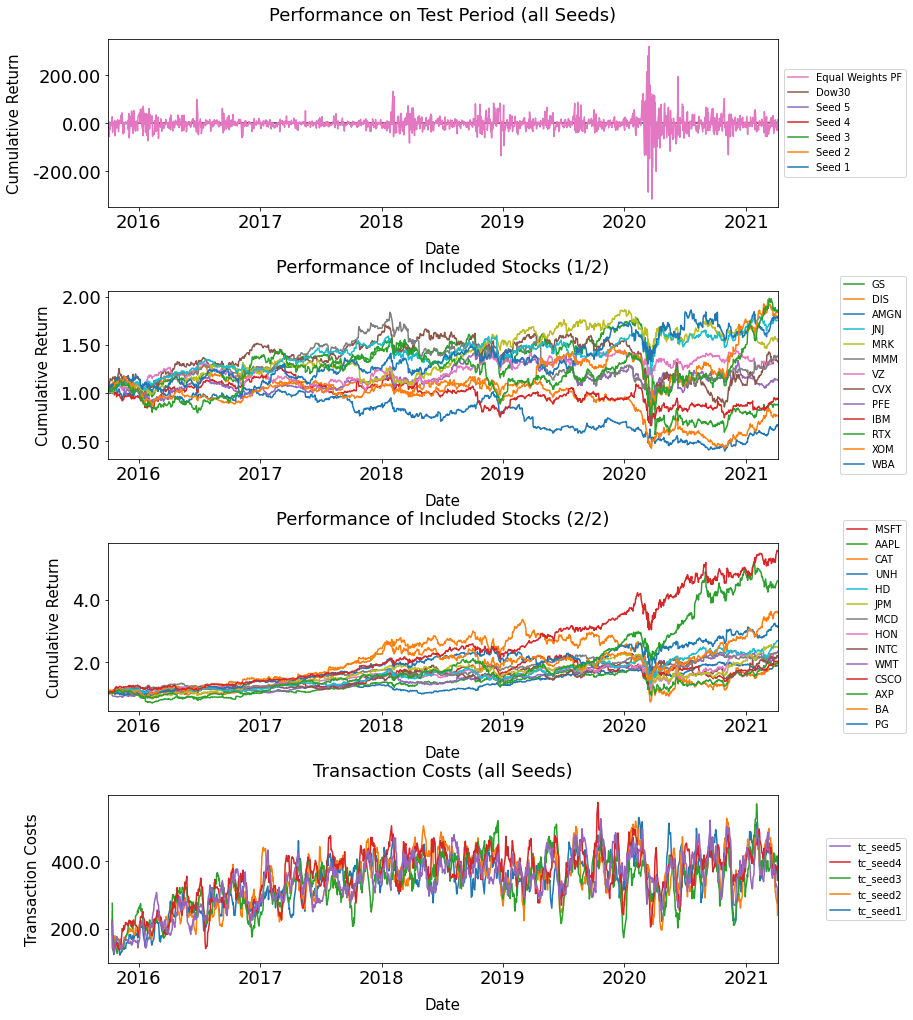

In [142]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

subplots = 4

legend_location= "right"
legend_location_exact = (1.2, 0.5) # (x, y, width, height)
legend_borderpad = 0.9
legend_borderaxespad = 0.
legend_fontsize = 16.
space_between_plots=0.5
NUM_COLORS = len(weightsinclcash_seed_list[0].columns.values)
#cm = plt.get_cmap("terrain")#"tab20b")#'gist_rainbow')
tickfont = 18
title_fontsize = 18
title_pad = 18.
label_fontsize = 15
label_pad = 10.

titles_list = ["Performance on Test Period (all Seeds)", 
               "Performance of Included Stocks (1/2)", 
               "Performance of Included Stocks (2/2)",
              "Transaction Costs (all Seeds)"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Cumulative Return", "Cumulative Return", "Cumulative Return", "Transaction Costs"]

# setting different parameters to adjust each grid
# https://www.delftstack.com/howto/matplotlib/how-to-make-different-subplot-sizes-in-matplotlib/
fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(12,17),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1, 1, 1, 1], 
                           'wspace': 0.1, 'hspace':space_between_plots})
lineslist = []
labellist = []
for col in pfval_full.columns.values:
    # plot cumulative returns
    ax[0].tick_params(axis='x', labelsize=tickfont)
    ax[0].tick_params(axis='y', labelsize=tickfont)
    ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[0].set_xlim(pfval_full.index[0], pfval_full.index[-1])
    #ax[0].set_ylim(-2, 0.7)
    ax[0].set_title(titles_list[0], fontsize=title_fontsize, pad=title_pad)
    ax[0].set_xlabel(x_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    ax[0].set_ylabel(y_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    #line, = ax[0].plot(pfval_full.index, np.log((pfval_full[col].pct_change()+1).cumprod()), label=col)
    line, = ax[0].plot(pfval_full.index, (pfval_full[col].pct_change()+1).cumprod(), label=col)
    lineslist.append(line)
    labellist.append(comp)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact)

lineslist = []
labellist = []
# do not plot all stocks in same plot because there are too many
for comp in tics_sorted[0:13]:
    subset = pd.DataFrame(us_df[us_df.tic == comp])[["datadate", "adjcp"]].set_index("datadate")
    ax[1].tick_params(axis='x', labelsize=tickfont)
    ax[1].tick_params(axis='y', labelsize=tickfont)
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[1].set_xlim(subset.index[0], subset.index[-1])
    #ax[1].set_ylim(-1, 0.7)
    ax[1].set_title(titles_list[1], fontsize=title_fontsize, pad=title_pad)
    ax[1].set_xlabel(x_labels_list[1], fontsize=label_fontsize, labelpad=label_pad)
    ax[1].set_ylabel(y_labels_list[1], fontsize=label_fontsize, labelpad=label_pad)
    #line, = ax[1].plot(subset.index, np.log((subset["adjcp"].pct_change()+1).cumprod()), label=comp)
    line, = ax[1].plot(subset.index, (subset["adjcp"].pct_change()+1).cumprod(), label=comp)
    lineslist.append(line)
    labellist.append(comp)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact)

lineslist = []
labellist = []
for comp in tics_sorted[13:]:
    subset = pd.DataFrame(us_df[us_df.tic == comp])[["datadate", "adjcp"]].set_index("datadate")
    ax[2].tick_params(axis='x', labelsize=tickfont)
    ax[2].tick_params(axis='y', labelsize=tickfont)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[2].set_xlim(subset.index[0], subset.index[-1])
    #ax[2].set_ylim(-1, 0.7)
    ax[2].set_title(titles_list[2], fontsize=title_fontsize, pad=title_pad)
    ax[2].set_xlabel(x_labels_list[2], fontsize=label_fontsize, labelpad=label_pad)
    ax[2].set_ylabel(y_labels_list[2], fontsize=label_fontsize, labelpad=label_pad)
    #line, = ax[2].plot(subset.index, np.log((subset["adjcp"].pct_change()+1).cumprod()), label=comp)
    line, = ax[2].plot(subset.index, (subset["adjcp"].pct_change()+1).cumprod(), label=comp)
    
    lineslist.append(line)
    labellist.append(comp)
handles, labels = ax[2].get_legend_handles_labels()
# reverse the order
ax[2].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact)

lineslist = []
labellist = []
for col in tc_seed_df.columns.values:
    ax[3].tick_params(axis='x', labelsize=tickfont)
    ax[3].tick_params(axis='y', labelsize=tickfont)
    ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[3].set_xlim(tc_seed_df.index[0], tc_seed_df.index[-1])
    #ax[3].set_ylim(-1, 0.7)
    ax[3].set_title(titles_list[3], fontsize=title_fontsize, pad=title_pad)
    ax[3].set_xlabel(x_labels_list[3], fontsize=label_fontsize, labelpad=label_pad)
    ax[3].set_ylabel(y_labels_list[3], fontsize=label_fontsize, labelpad=label_pad)
    line, = ax[3].plot(tc_seed_df.index, tc_seed_df[col].rolling(window=10).mean(), label=col)
    
    lineslist.append(line)
    labellist.append(comp)
handles, labels = ax[3].get_legend_handles_labels()
# reverse the order
ax[3].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact)

### FINAL WEIGHTS PLOT

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


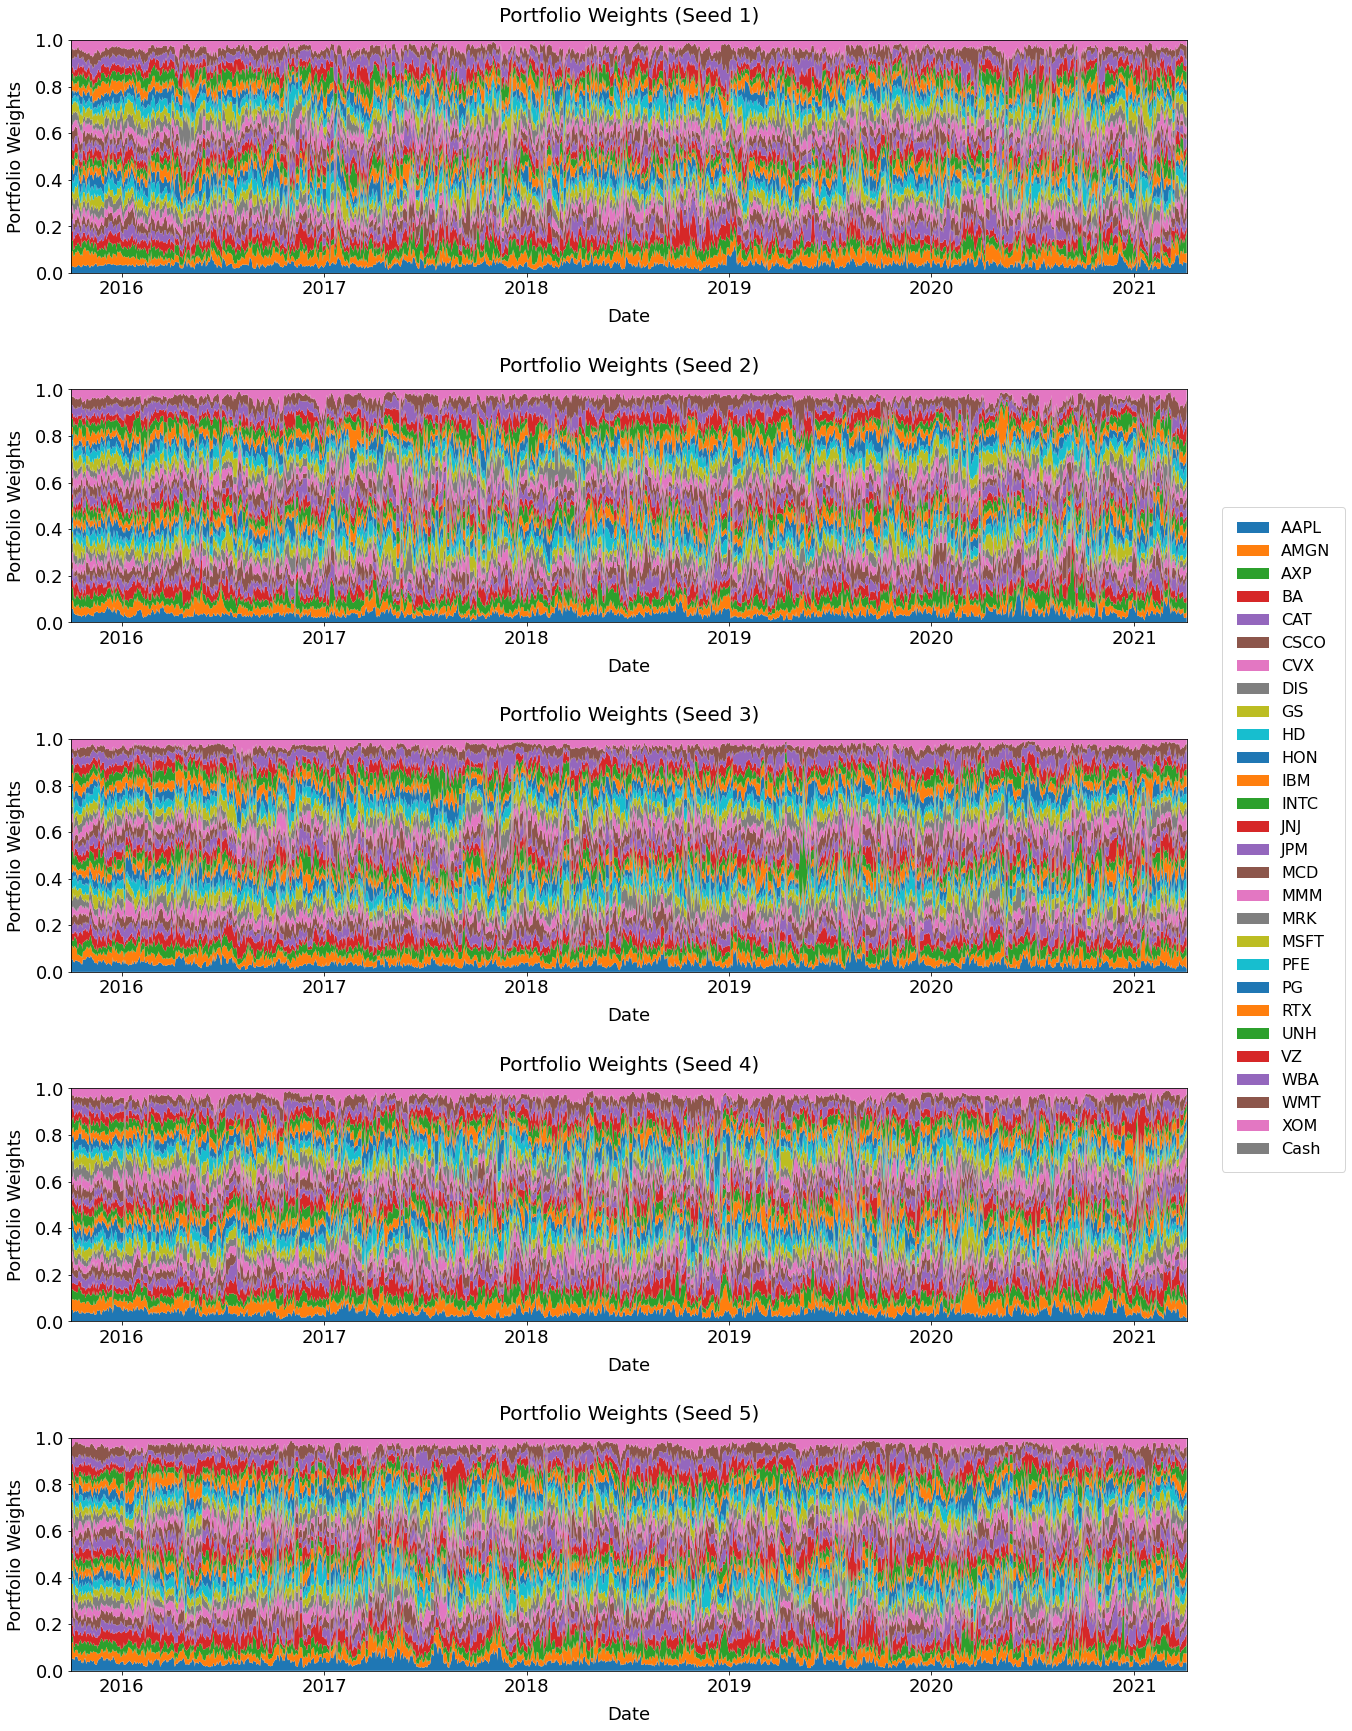

In [56]:
### SEPARATE PLOT FOR PORTFOLIO WEIGHTS BECAUSE ELSE IT IS MESSY

subplots = len(weightsinclcash_seed_list)
title_fontsize = 20
label_fontsize = 18
tickfont = 18
title_pad = 18.
label_pad = 10.
titles_list = [ "Portfolio Weights (Seed 1)", "Portfolio Weights (Seed 2)", 
              "Portfolio Weights (Seed 3)", "Portfolio Weights (Seed 4)", "Portfolio Weights (Seed 5)"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Portfolio Weights", "Portfolio Weights", 
              "Portfolio Weights", "Portfolio Weights", "Portfolio Weights"]
legend_location= "right"
legend_location_exact = (0.01, -0.04, 1, 1.1)#(0.01, -0.04, 1.12, 1.1) # (right_loc, loc,up_loc, right_loc, up_loc) = (right_loc, up_loc), 
                                            # in relation to legend_location
legend_borderpad = 0.9
legend_borderaxespad = 0.
legend_fontsize = 16.
space_between_plots=0.5
lines_list = []

NUM_COLORS = len(weightsinclcash_seed_list[0].columns.values)
#cm = plt.get_cmap("terrain")#"tab20b")#'gist_rainbow')

fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(20,30),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1, 1, 1, 1, 1], 
                           'wspace': 0.1, 'hspace': space_between_plots})



for seednum, wdf in enumerate(weightsinclcash_seed_list):
    axindex = seednum
    #ax[axindex].set_prop_cycle('color', [cm(1 * i / NUM_COLORS) for i in range(NUM_COLORS)])
    ax[axindex].tick_params(axis='x', labelsize=tickfont)
    ax[axindex].tick_params(axis='y', labelsize=tickfont)
    ax[axindex].set_xlim(wdf.index[0], wdf.index[-1])
    ax[axindex].set_ylim(0, 1)
    ax[axindex].set_title(titles_list[axindex], fontsize=title_fontsize, pad=title_pad)
    ax[axindex].set_xlabel(x_labels_list[axindex], fontsize=label_fontsize, labelpad=label_pad)
    ax[axindex].set_ylabel(y_labels_list[axindex], fontsize=label_fontsize, labelpad=label_pad)
    p = ax[axindex].stackplot(wdf.index, wdf["AAPL"], wdf["AMGN"],wdf["AXP"], wdf["BA"], wdf["CAT"], wdf["CSCO"],
                         wdf["CVX"], wdf["DIS"], wdf["GS"], wdf["HD"], wdf["HON"], wdf["IBM"], wdf["INTC"], 
                         wdf["JNJ"], wdf["JPM"], wdf["MCD"], wdf["MMM"], wdf["MRK"], wdf["MSFT"], wdf["PFE"], 
                         wdf["PG"], wdf["RTX"], wdf["UNH"], wdf["VZ"], wdf["WBA"], wdf["WMT"], wdf["XOM"],
                          wdf["Cash"], 
                          )
    if axindex == 0: 
        lines_list.append(p)
labels=['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD',
                          'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE',
                          'PG', 'RTX', 'UNH', 'VZ', 'WBA', 'WMT', 'XOM', 'Cash']

#lines_list = [lines_list[0][::-1]]
#labels = labels[::-1]

fig.legend(lines_list, labels=labels, loc=legend_location,
               bbox_to_anchor=legend_location_exact,  # (x, y, width, height) 
               borderaxespad=legend_borderaxespad,
               borderpad=legend_borderpad, fontsize=legend_fontsize,
               ncol=1)
#fig.tight_layout()
#fig.subplots_adjust(hspace=space_between_plots)
#ax[0].legend(loc='upper right')

In [275]:
#labels[::-1]

In [286]:
lines_list[0][::-1]

In [283]:
lines_list #[[<matplotlib.collections.PolyCollection at 0x1fb2d729988>,

[[<matplotlib.collections.PolyCollection at 0x1fb2d729988>,

In [282]:
weightsinclcash_seed_list[0].columns

Index(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD',
       'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE',
       'PG', 'RTX', 'UNH', 'VZ', 'WBA', 'WMT', 'XOM', 'Cash'],
      dtype='object')

In [ ]:

# for each subplot
for i in range(0, subplots):
    # assign subplot labels and titles
    title = titles_list[i]
    x_label = x_labels_list[i]
    y_label = y_labels_list[i]
    #ylim_left = ylim_left_list[i]
    #ylim_right = ylim_right_list[i]

    axs[i].set_prop_cycle('color', [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)])
    axs[i].set_title(title, fontsize=title_fontsize, pad=title_pad)
    axs[i].set_xlabel(x_label, fontsize=label_fontsize, labelpad=label_pad)
    axs[i].set_ylabel(y_label, fontsize=label_fontsize, labelpad=label_pad)
    # axs[i].set_xlim(xlim_left, xlim_right)
    # axs[i].ticklabel_format(useOffset=False, style="plain")
    if i == 0:
        from matplotlib.ticker import FuncFormatter
        axs[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[i].set_ylim(ylim_left, ylim_right)
    
    for comp_name in comp_names_list:
        subset = df_.loc[df_[comp_name_column] == comp_name]
        if i == 0:
            p = axs[i].plot(subset[x_col], subset[y_col])
            lines_list.append(p)
        else:
            if not subset.empty:
                axs[i].plot(subset[x_col], subset[y_col])
try:
    labs = comp_names_list[:len(lines_list) - 1]
    fig.legend(lines_list, labels=labs, loc=legend_location,
               bbox_to_anchor=legend_location_exact,  # (x, y, width, height) 
               borderaxespad=legend_borderaxespad,
               borderpad=legend_borderpad, fontsize=legend_fontsize,
               ncol=1)
    fig.tight_layout()
    fig.subplots_adjust(hspace=space_between_plots)
    plt.show()
except:
    pass

Text(0.5, 1.0, 'Cumulative Porftolio Returns Test Set \n over whole Time Series, for 5 Seeds \n vs. Dow30 index')

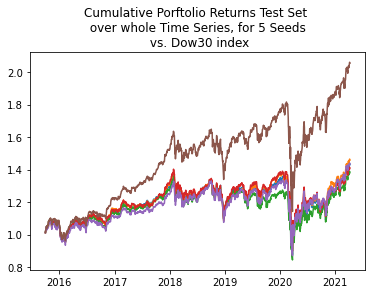

In [96]:
# plot all seeds in one plot
for col in pfval_full.columns.values:
    plt.plot(pfval_full.index, (pfval_full[col].pct_change()+1).cumprod())
plt.title(f"Cumulative Porftolio Returns Test Set \n over whole Time Series, for 5 Seeds \n vs. Dow30 index")


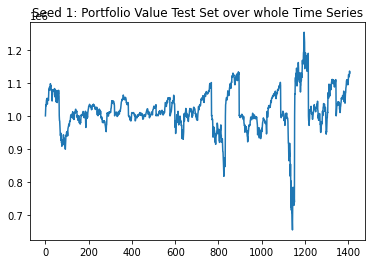

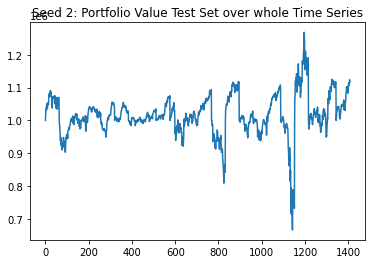

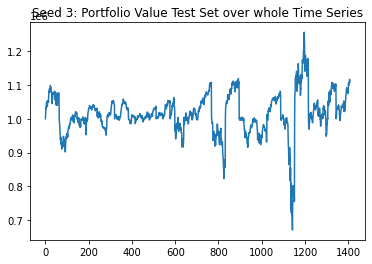

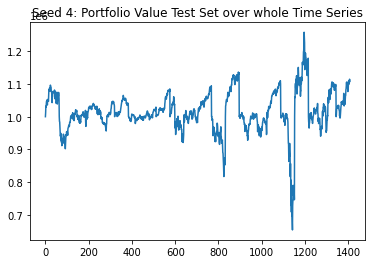

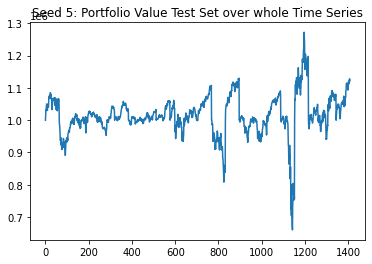

In [15]:
### CUMULATIVE PF RETURN OVER TIME, VALIDATION SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                          seed, 
                                          "portfolio_value", 
                                          f"portfolio_value_validation_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_52.csv")
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "pfval"}, inplace=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    plt.plot(final_df.index, final_df.pfval)
    plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

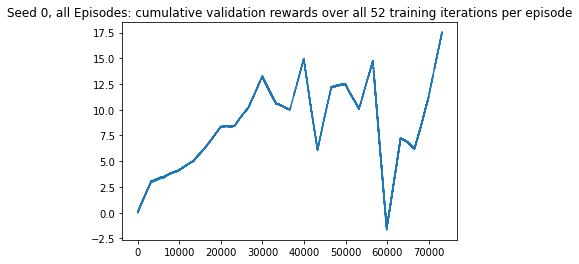

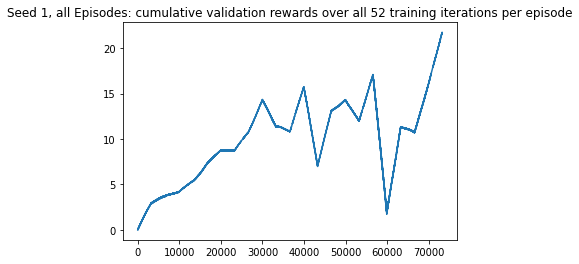

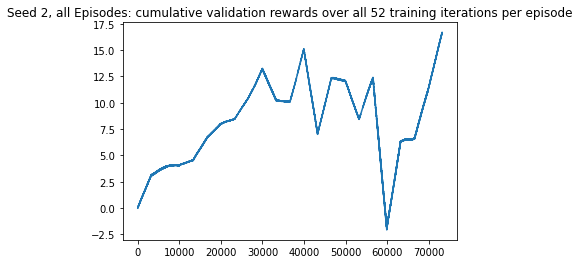

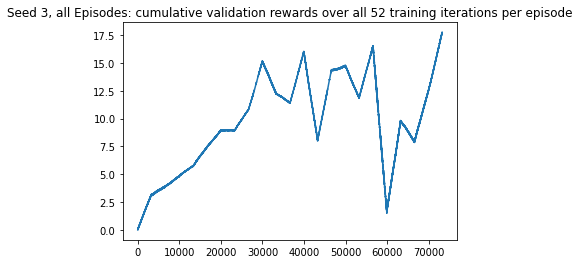

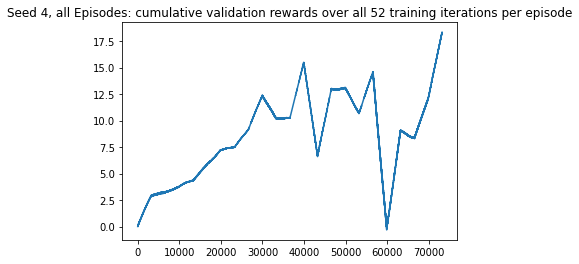

In [7]:
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        li=[]
        for i in range(1,53):
            filepath = glob.glob(os.path.join(results_folder_path, seed, "rewards", f"*validation*ep{ep}_*er_{i}.csv"))[0]
            df = pd.read_csv(filepath, index_col=0)
            df.rename(columns={df.columns[1]: "reward"}, inplace=True)
            li.append(df)
        df = pd.concat(li, axis=0, ignore_index=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    plt.plot(final_df.index, final_df.reward.cumsum())
    plt.title(f"Seed {seednum+1}, all Episodes: cumulative validation rewards over all 52 training iterations per episode")
    plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

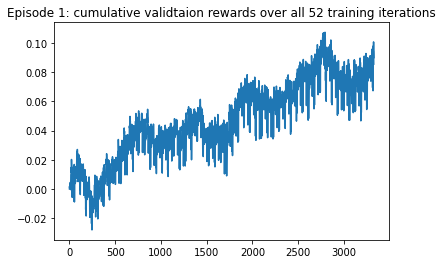

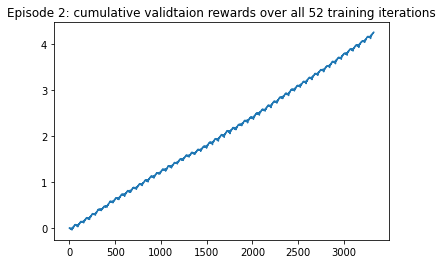

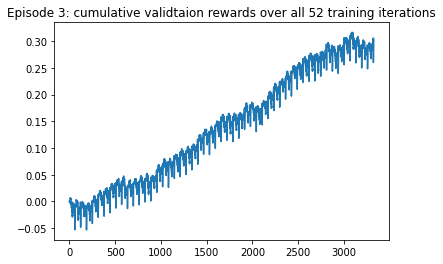

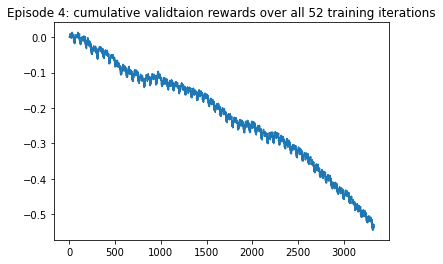

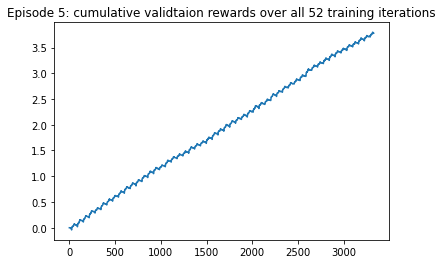

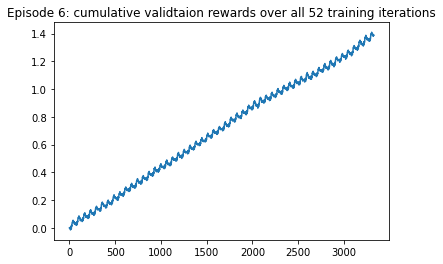

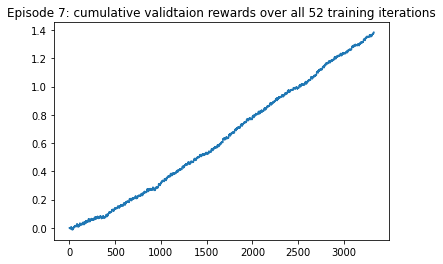

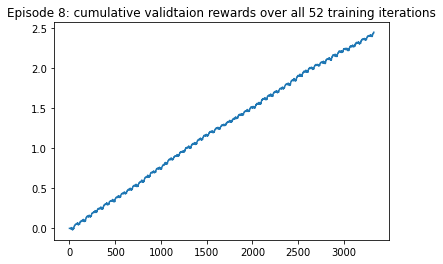

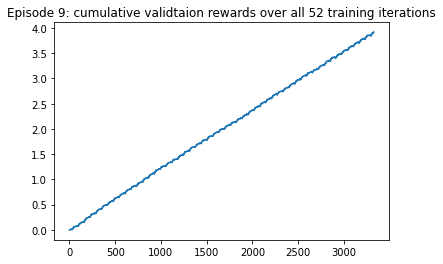

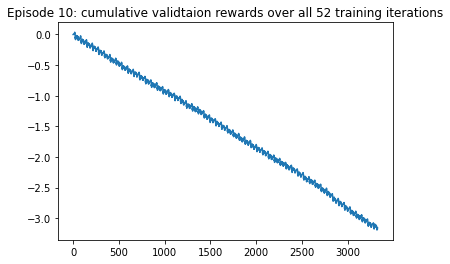

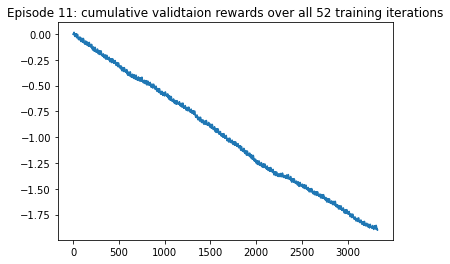

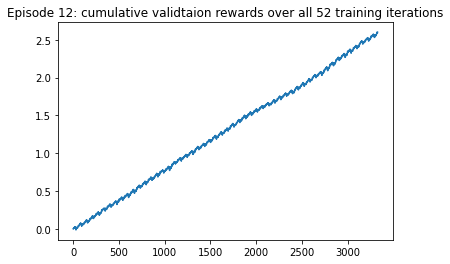

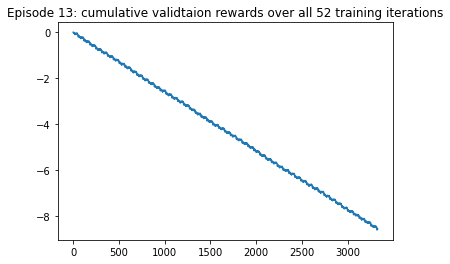

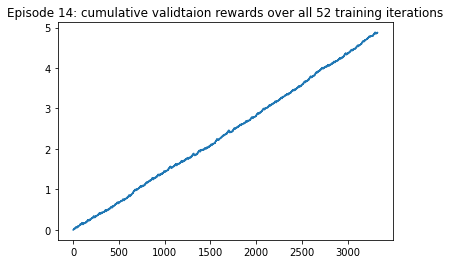

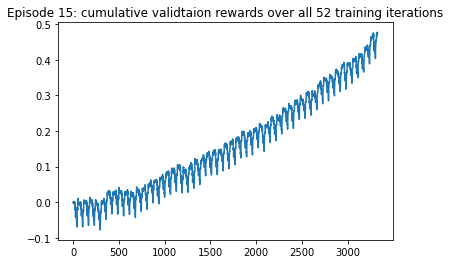

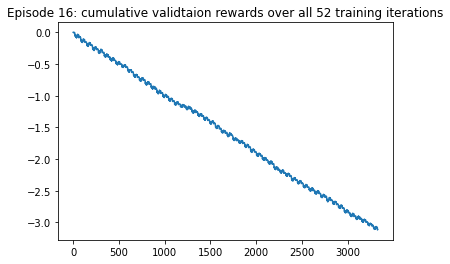

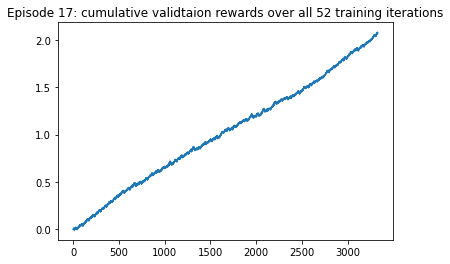

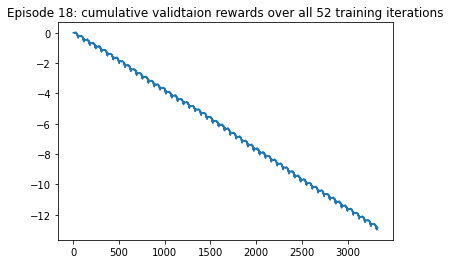

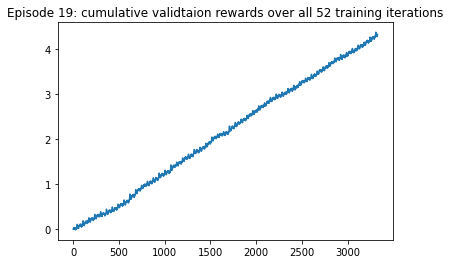

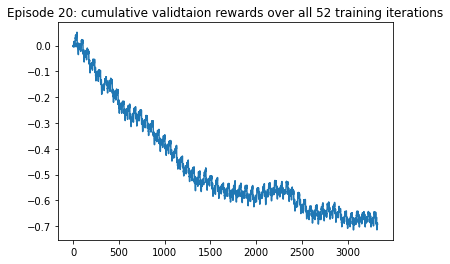

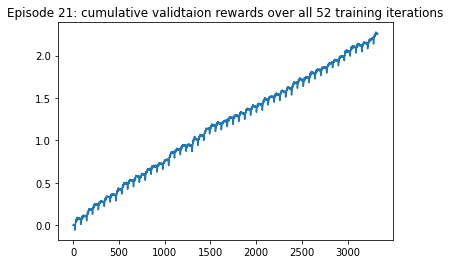

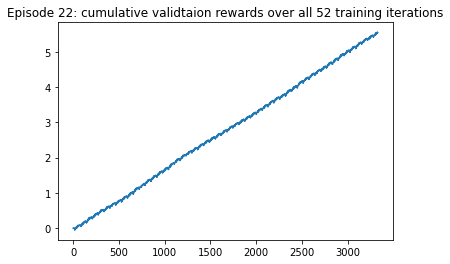

<Figure size 432x288 with 0 Axes>

In [91]:
# cum rewards fo rone seed over all timesteps but only 1 seed; we see that in certain episodes we
# are not getting better but worse
for ep in range(1,23):
    li=[]
    for i in range(1,53):
        filepath = glob.glob(os.path.join(results_folder_path, seed1, "rewards", f"*validation*ep{ep}_*er_{i}.csv"))[0]
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "reward"}, inplace=True)
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)
    df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
    df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
    plt.plot(df.index, df.reward.cumsum())
    plt.title(f"Episode {ep}: cumulative validtaion rewards over all 52 training iterations")
    plt.show()
    plt.clf()

In [ ]:
### TRAINING PERFORMANCE

In [ ]:
# EXPLAINED VARIANCE (train set, over all training iterations)


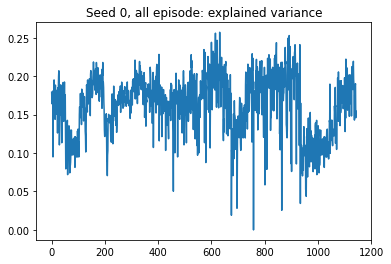

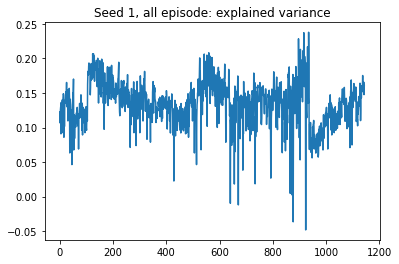

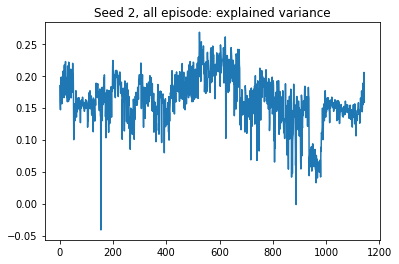

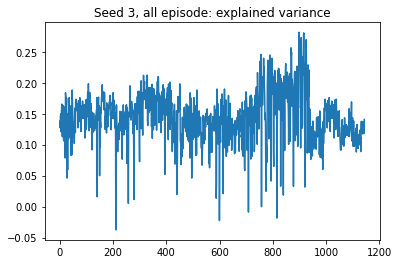

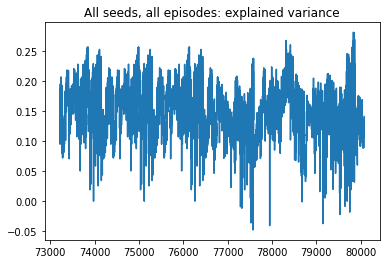

<Figure size 432x288 with 0 Axes>

In [102]:
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    li = []
    for ep in range(1,23):
        filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                          f"explained_variance_*ep{ep}*.csv"))[0]
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[0]: "explained_variance"}, inplace=True)
        #plt.plot(final_df.index, final_df.explained_variance)
        #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
        #plt.show()
        #plt.clf()
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.plot(df.index, df.explained_variance)
    plt.title(f"Seed {seednum}, all episode: explained variance")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong
final_df = pd.concat(all_li, axis=0, ignore_index=True)
plt.plot(final_df.index, final_df.explained_variance)
plt.title(f"All seeds, all episodes: explained variance")
plt.show()
plt.clf()

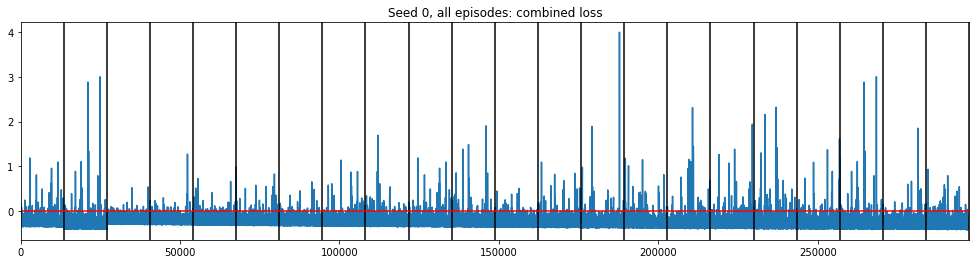

<Figure size 432x288 with 0 Axes>

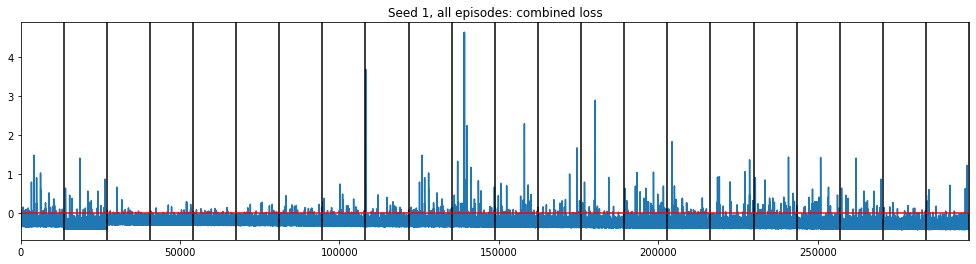

<Figure size 432x288 with 0 Axes>

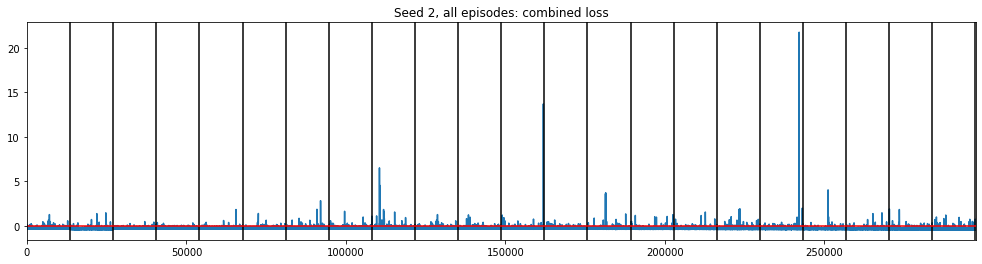

<Figure size 432x288 with 0 Axes>

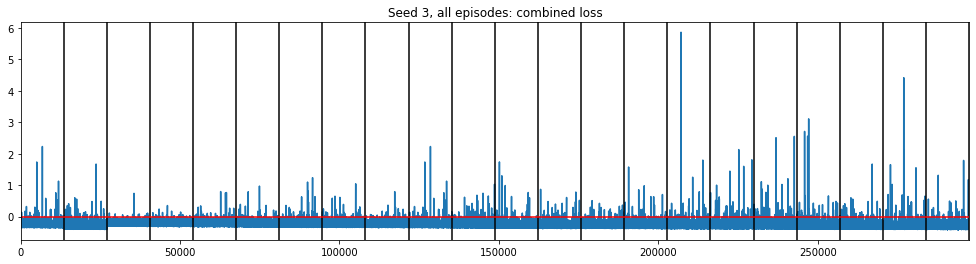

<Figure size 432x288 with 0 Axes>

In [123]:
### TRAIN PERFORMANCES: COMBINED LOSS
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    li = []
    for ep in range(1,23):
        filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                          f"train_performances_ep{ep}*.csv"))[0]
        df = pd.read_csv(filepath, index_col=0)
        # plot
        #plt.plot(df.index, df.actor_loss)
        #plt.axvline(x=epwindow_end)
        #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
        #plt.show()
        #plt.clf()
        li.append(df)
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, df_all.combined_loss)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: combined loss")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong

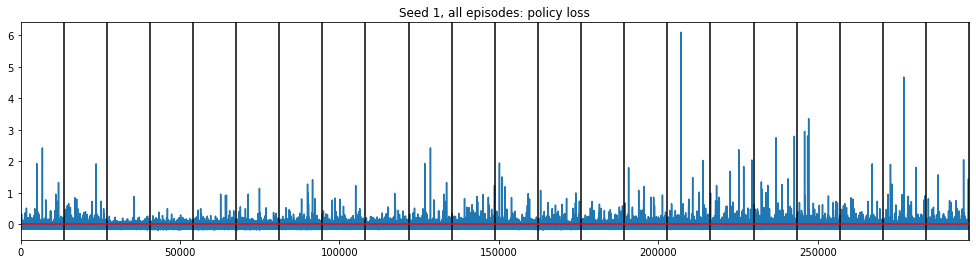

<Figure size 432x288 with 0 Axes>

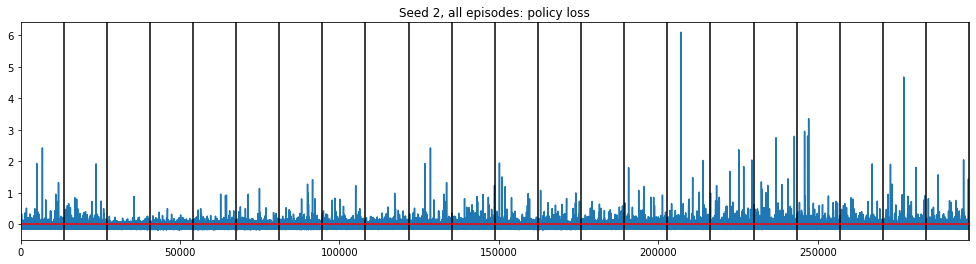

<Figure size 432x288 with 0 Axes>

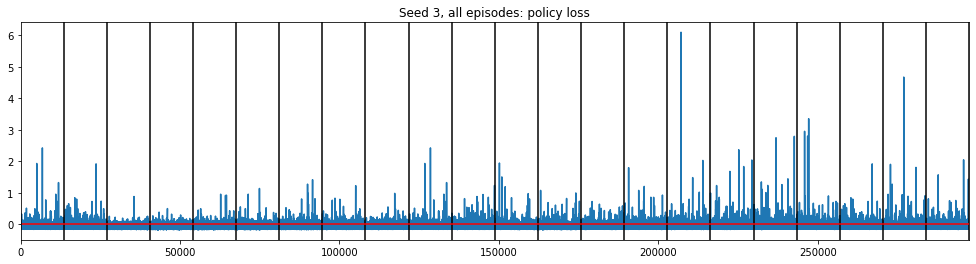

<Figure size 432x288 with 0 Axes>

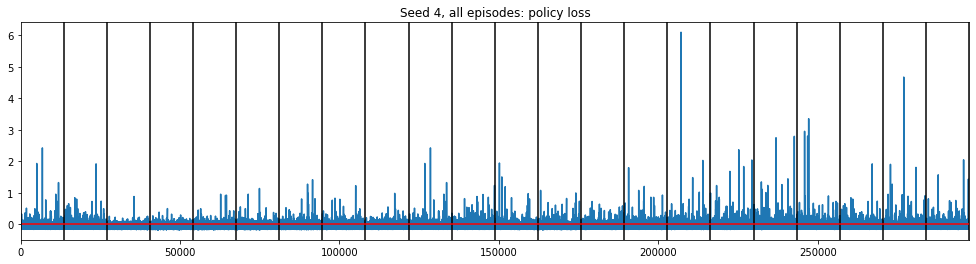

<Figure size 432x288 with 0 Axes>

In [124]:
### TRAIN PERFORMANCES: ACTOR LOSS (POLICY LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, df_all.actor_loss)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: policy loss")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong

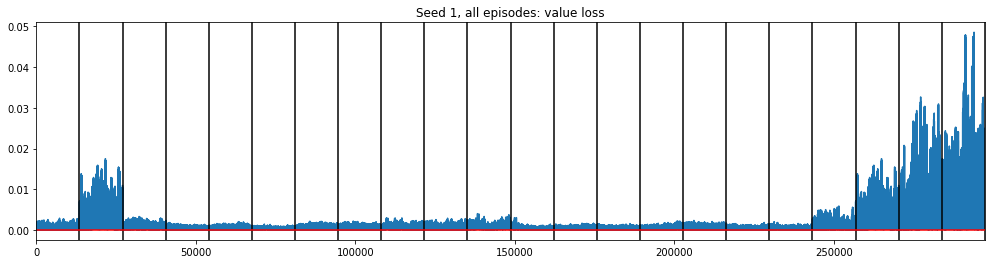

<Figure size 432x288 with 0 Axes>

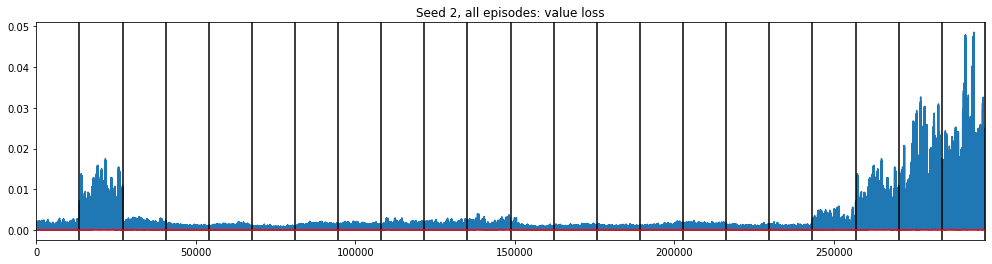

<Figure size 432x288 with 0 Axes>

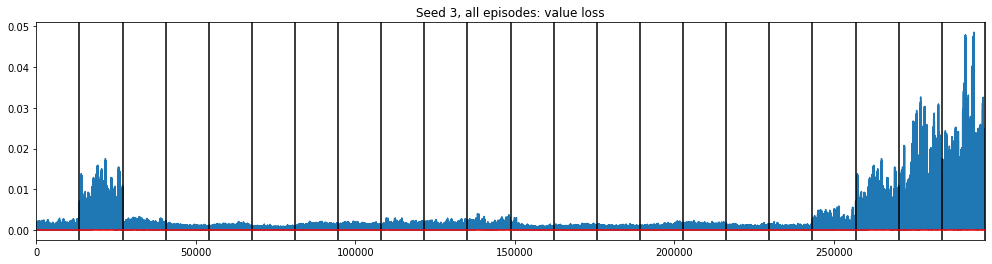

<Figure size 432x288 with 0 Axes>

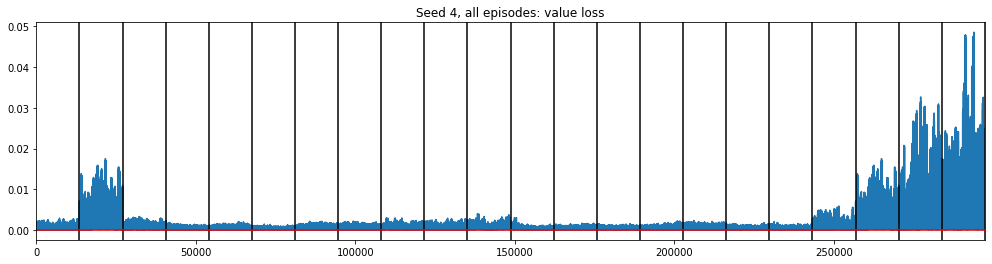

<Figure size 432x288 with 0 Axes>

In [125]:
### TRAIN PERFORMANCES: CRITIC LOSS (VALUE LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, df_all.critic_loss)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: value loss")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong

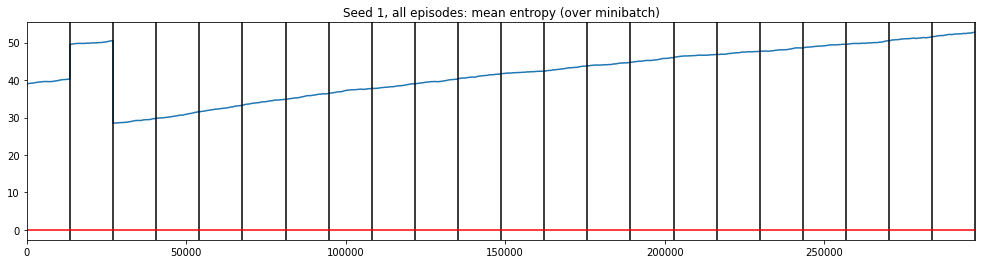

<Figure size 432x288 with 0 Axes>

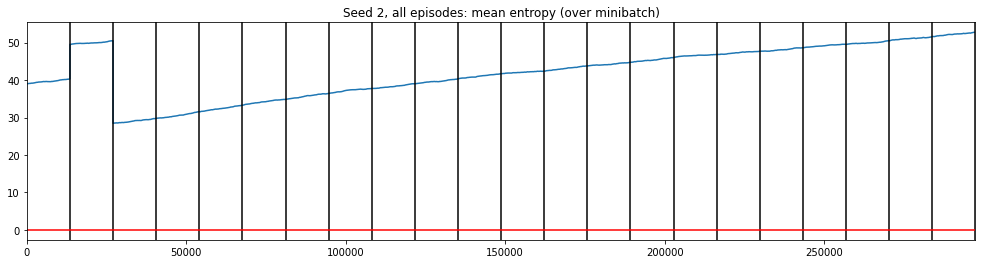

<Figure size 432x288 with 0 Axes>

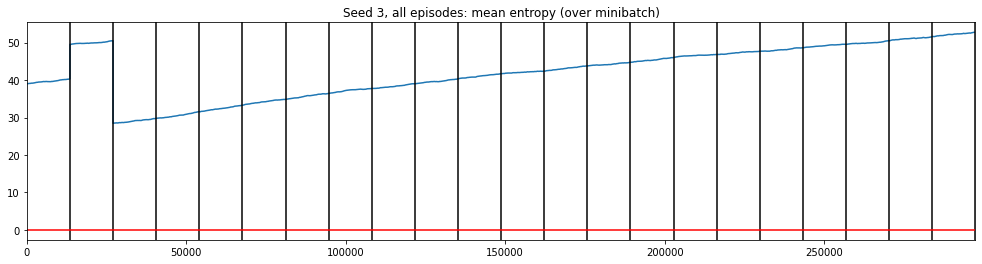

<Figure size 432x288 with 0 Axes>

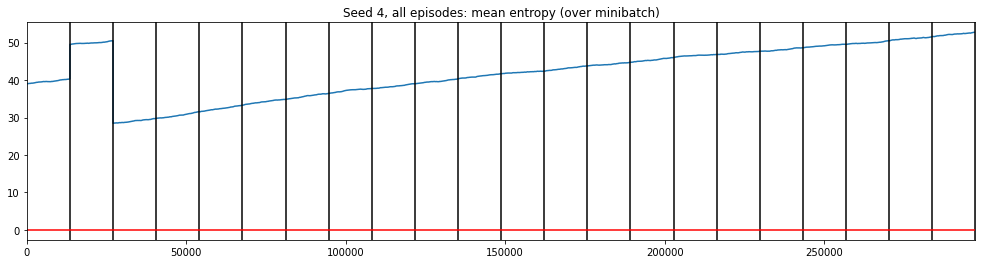

<Figure size 432x288 with 0 Axes>

In [127]:
### TRAIN PERFORMANCES: MEAN ENTROPY (-MEAN ENTROPY LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, (-1)*df_all.entropy_loss)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: mean entropy (over minibatch)")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong
    
# entropy loss starts high at the beginning of each episode and then drops
# https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2
# shows how random actions are. Should decrease steadily during training process. Here looks ok.
# Entropy: "the higher the more bonus" => to max.
# Entropy loss = neg. Entropy => to min. => "the lower, the better"
# idea is that in the beginning, we get a bonus for more exploration

# about losses: 
# https://www.reddit.com/r/reinforcementlearning/comments/bse7l5/rl_ppo_alrorithm_understanding_value_loss_and/

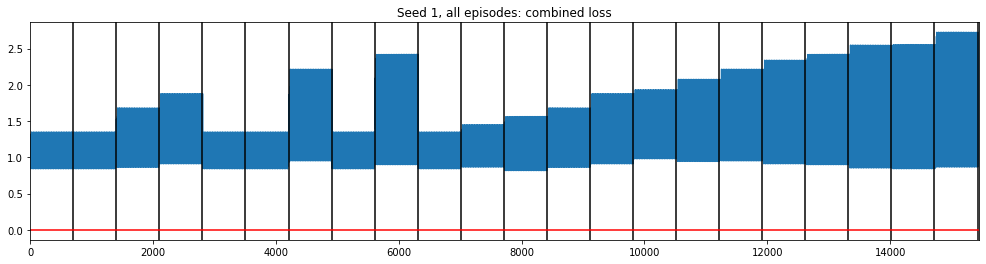

<Figure size 432x288 with 0 Axes>

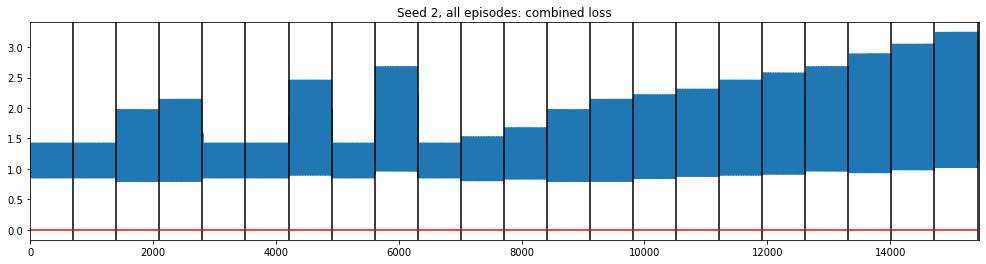

<Figure size 432x288 with 0 Axes>

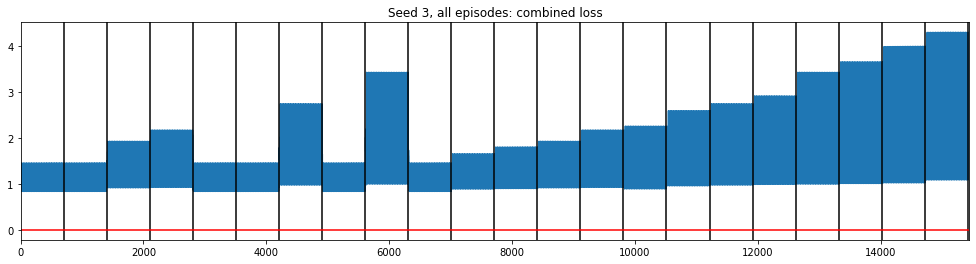

<Figure size 432x288 with 0 Axes>

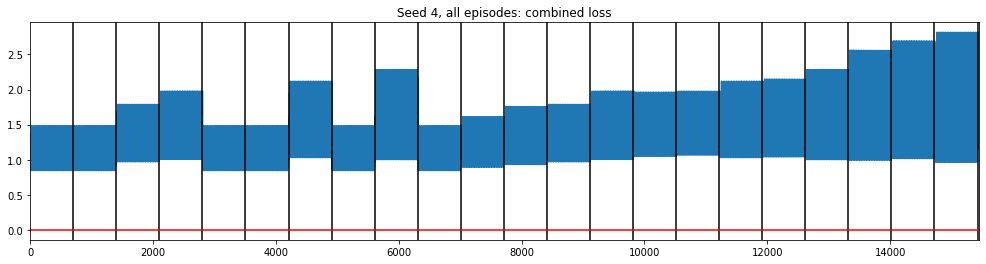

<Figure size 432x288 with 0 Axes>

In [128]:
### TRAIN PERFORMANCES: STANDARD DEVIATIONS
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    li = []
    for ep in range(1,23):
        filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                          f"standard_deviations*{ep}*.csv"))[0]
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[0]: "standard_deviation"}, inplace=True)
        # plot
        #plt.plot(df.index, df.actor_loss)
        #plt.axvline(x=epwindow_end)
        #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
        #plt.show()
        #plt.clf()
        li.append(df)
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, df_all.standard_deviation)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: combined loss")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong